In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = None
np.random.seed(0)

In [2]:
data = pd.read_pickle("../Data/Data.pickle")

data["Month"] = data.index.month
data["Week"] = data.index.week
data["Day"] = data.index.dayofweek

/tmp/ipykernel_3796/1280399527.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data["Week"] = data.index.week


# The Epochs
## Removing trends/seasonality
Let's begin by clearly explaining our situation.
As mentioned before, this is achieved through graphs which break down our time series!
They help us visually interpret precisely what needs to be removed/modified.

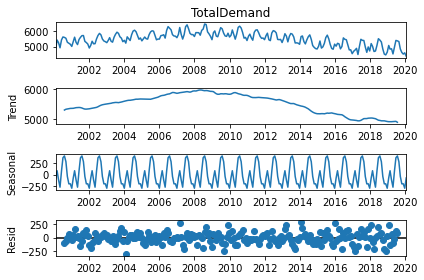

In [3]:
seasonal_decompose(data.groupby("Region").get_group("VIC")["TotalDemand"].resample("M").mean(), model="additive").plot();

The full graphs are at the top, with *trends* (values growing or decreasing over time), *seasonality* (a repeating pattern of increasing and then declining values), and *residuals* (everything else that is present, but more random because it doesn't seem to repeat itself) below.


We just deconstructed Victoria's energy demand here, so it's not quite reflective of what we'll eliminate, but it's near enough to make the point.
We wish to get rid of the long-term tendency of increasing and declining.
This is usually accomplished by *diffing* our data (subtracting $n$ from each entry).
We'll deduct the figure from half a year ago because our trends are long-term.
We must first order because we do it separately for each state.

In [4]:
# Sort dataframe by region so groupby's output can be combined and used for another column
data.sort_values(by=["Region", "Date"], inplace=True)
data["AdjustedDemand"] = data.groupby("Region")["TotalDemand"].diff(8544)
all([region[1].sort_index().index.equals(region[1].index) for region in data.groupby("Region")])
data.sort_index(inplace=True)

True

When we graph the original total demand we find that it was not stationary, however, when we overlay the new adjusted version it varies up and down across one straight line (implying that the trend has been removed).

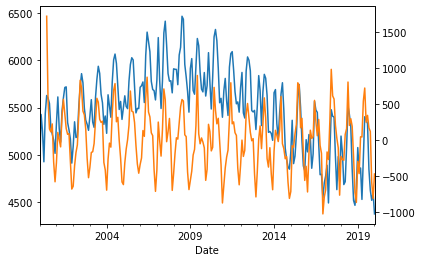

In [5]:
data.groupby("Region").get_group("VIC")["TotalDemand"].resample("M").mean().plot();
data.groupby("Region").get_group("VIC")["AdjustedDemand"].resample("M").mean().plot(secondary_y=True);

To ensure we're right, we can graph the distribution of temperature against energy, and see how it changes with time.
We can see that the graphs become tighter, showing how that the number of energy values for a certain temperature has been reduced (good)!

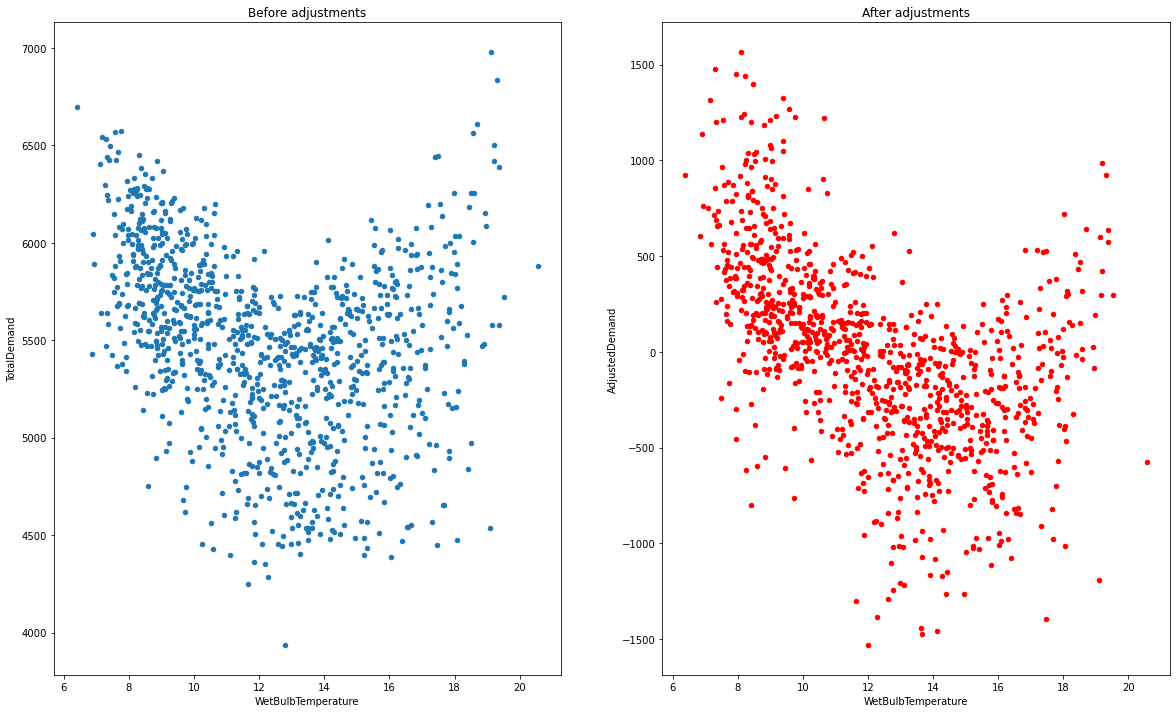

In [6]:
fix, axes = plt.subplots(ncols=2, figsize=(20, 12))
data.groupby("Region").get_group("VIC").resample("W").mean().plot(x="WetBulbTemperature", y="TotalDemand", kind="scatter", ax=axes[0], title="Before adjustments");
data.groupby("Region").get_group("VIC").resample("W").mean().plot(x="WetBulbTemperature", y="AdjustedDemand", kind="scatter", ax=axes[1], title="After adjustments", color="red");

## Divide up data
So now we have to divide it out and be certain it's exactly what we're searching for.
For our purposes, the default distribution of 75% of data for training and 25% for testing is sufficient.
Because not everyone has access to a supercomputer, we'll merely forecast overall energy usage per day to make it easy and quick to train our model (good for rapidly seeing how our model performs, test tweaking a few things, and retrain) (instead of per 30 minutes).
This should also reduce the impact of any existing outliers!
One thing that will become instantly apparent while testing out modifications is the need of including comprehensive information on time.

In [7]:
resampled_data = data.groupby("Region").resample("D").mean().reset_index("Region").sort_index()
train_data, test_data = train_test_split(resampled_data, shuffle=False)

input_columns = ["WetBulbTemperature", "Month", "Week", "Day"]
output_columns = ["AdjustedDemand"]

train_input_data, train_output_data = train_data[input_columns + ["Region"]], train_data[output_columns + ["Region"]]
test_input_data, test_output_data = test_data[input_columns + ["Region"]], test_data[output_columns + ["Region"]]

## Create and train a model
We have a vast number of models to choose from.
We can experiment to see which ones work (a nice concept for beginners), but after many tries, it becomes clear that basic and fast models such as decision trees perform just as well as more complex ensemble models such as random forests.
Of obviously, linear models are ineffective (our data is shaped like a parabola in most cases).
We need to identify the optimal hyperparameters (how deep and complex our decision tree may get), and grid search is the typical technique to do it (https://www.kamwithk.com/machine-learning-field-guide-ckbbqt0iv025u5ks1a7kgjckx#hyperparameter-tuning).
Over 5 subsets of our dataset, we execute [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model selection.GridSearchCV.html) (K-fold cross-validation).
Our hyperparameters (placed into a "paramaters" array) are max depth (how *deep* the tree can grow), min sample leaves (minimum end-nodes the tree must have, which makes shallow trees), and max-leaf nodes (maximum end-nodes the tree is permitted to have, which produces deeper trees).
We discovered them via [reading the decision-tree Scikit Learn documentation](https://scikit-learn.org/stable/modules/tree.html), which contains a wealth of information on how to apply each model (and with some examples)!
Manual testing is required to determine which specific values to try for each variable (try and see what happens).


Here, the "'get best model"' function is in charge of hyperparameter tuning, while the "'get predictions"' function loops through each state and trains a model for it.
It's a good idea to separate different notions into their own functions/classes.

In [8]:
def get_best_model(test_input: pd.DataFrame, test_output: pd.DataFrame):
    paramaters = {"max_depth": [*range(1, 20), None], "min_samples_leaf": [2, 5, 10, 15], "max_leaf_nodes": [5, 10, 20, None]}
    regressor = DecisionTreeRegressor()
    grid = GridSearchCV(regressor, param_grid=paramaters, n_jobs=1)
    grid.fit(test_input, test_output.values.ravel())
    best_score, best_depth = grid.best_score_, grid.best_params_
    
    return grid, best_score, best_depth

In [9]:
def get_predictions(regressor, test_input, test_output, train_input=None, train_output=None):
    test_predictions = regressor.predict(test_input)
    test_results = pd.DataFrame(test_predictions, columns=output_columns, index=test_input.index)
    test_results = test_data[input_columns].join(test_results)
    
    if type(train_input) != None and type(train_output) != None:
        train_predictions = regressor.predict(train_input)
        train_results = pd.DataFrame(train_predictions, columns=output_columns, index=train_input.index)
        train_results = train_data[input_columns].join(train_results)
        
        return test_results, train_results
    return test_results

In [10]:
models, regressors = [], []

test_predictions, train_predictions = [], []

for region, dataframe in train_data.groupby("Region"):
    # Cross validate to find the best model
    model_input, model_output = dataframe.dropna()[input_columns], dataframe.dropna()[output_columns]
    grid, score, params = get_best_model(model_input, model_output)
    regressors.append(grid)
    models.append(regressors[-1].fit(model_input, model_output.values.ravel()))
    
    print(f"Best {region} model has a score of {score} and best params {params}")
    
    # Get the test data for this specific region
    test_input = test_data.groupby("Region").get_group(region)[input_columns].dropna()
    test_output = test_data.groupby("Region").get_group(region)[output_columns].dropna()
    
    # Generate predictions, obtain and log the final formatted data
    test_results, train_results = get_predictions(regressors[-1], test_input, test_output, model_input, model_output)
    test_predictions.append(test_results)
    train_predictions.append(train_results)

Best NSW model has a score of 0.6667686022629173 and best params {'max_depth': 11, 'max_leaf_nodes': None, 'min_samples_leaf': 15}
Best QLD model has a score of 0.6790984547514624 and best params {'max_depth': 11, 'max_leaf_nodes': None, 'min_samples_leaf': 15}
Best SA model has a score of 0.4217953384448957 and best params {'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
Best TAS model has a score of 0.7595450288835889 and best params {'max_depth': 9, 'max_leaf_nodes': None, 'min_samples_leaf': 15}
Best VIC model has a score of 0.6289316131288698 and best params {'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 10}


With a score of slightly under 80%, we can see that Tasmania does fairly well.
This makes reasonable because Tasmania began with minimal trend, implying a stronger relationship between temperature and energy.
Queensland, New South Wales, and Victoria aren't far behind, with scores ranging from 60% to 70%!

We can also see that our models aren't as complicated as they may be by looking at the'max depth'.

## Visualize Results
We make and analyse energy and temperature charts to see how well our model performs.
We begin by looking at the relationship between energy and temperature in each condition (the predictions are blue, and the real values are red).
We can see that the model isn't flawless, and that it doesn't always anticipate the correct outcome.

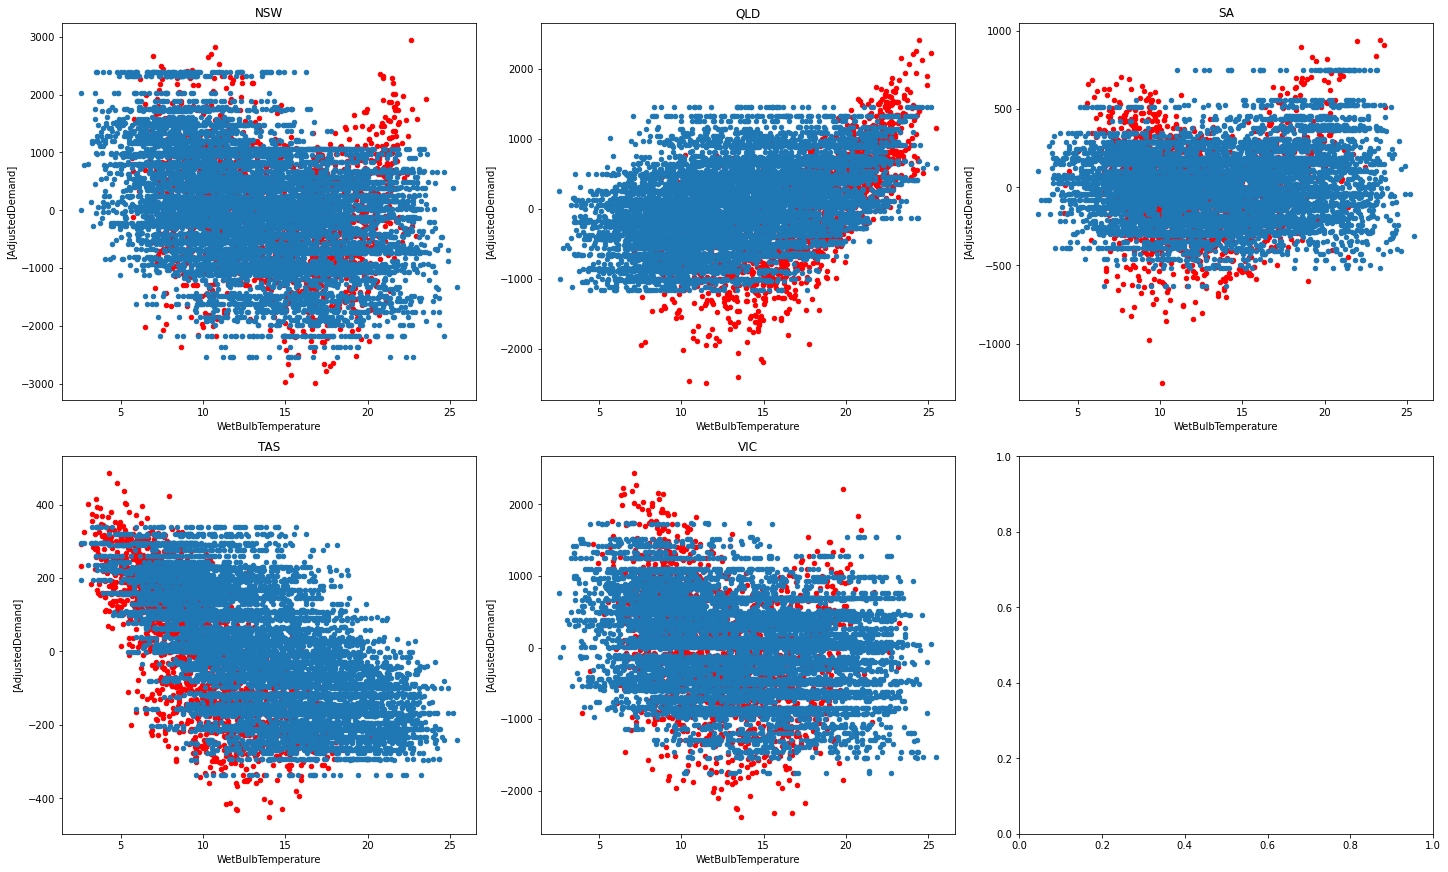

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), constrained_layout=True)
counter = [0, 0]
        
for region, region_data in test_data.groupby("Region"):
    region_data.plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y=output_columns, kind="scatter", color="red", title=region)
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1

counter = [0, 0]

for region_data in test_predictions:
    region_data.plot(ax=axes[counter[0], counter[1]], x="WetBulbTemperature", y=output_columns, kind="scatter")
    
    if counter[1] < 2: counter[1] += 1
    elif counter[1] == 2: counter[1] = 0; counter[0] += 1
        
pass;

The majority of the time, the forecasts match the actual facts, but there are times when they don't.
We can see that Tasmania and Queensland have done a fantastic job (explaining their high performance).
Their graphs appear to be more linear and less curved, which could explain why they outperform other states.

Now we may turn our attention to the energy time series.

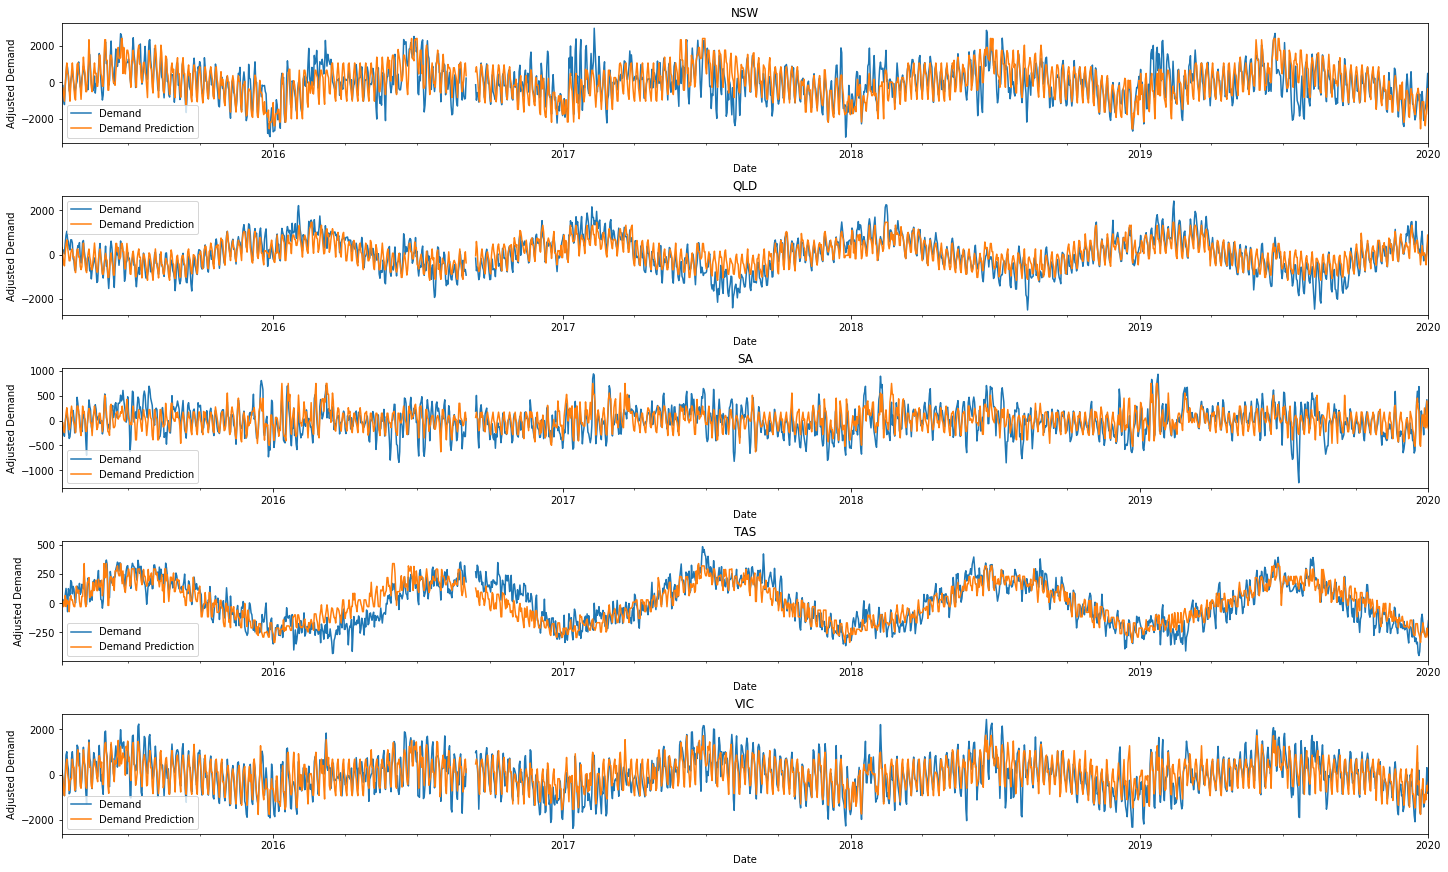

In [12]:
fig, axes = plt.subplots(nrows=5, figsize=(20, 12), constrained_layout=True)
        
for i, (region, region_data) in enumerate(test_data.groupby("Region")):
    region_data[output_columns].plot(ax=axes[i], title=region)
    test_predictions[i][output_columns].plot(ax=axes[i])
    axes[i].set_ylabel("Adjusted Demand")
    axes[i].legend(["Demand", "Demand Prediction"])
pass;

The general ups and downs can be seen to be *mostly* found and predicted over time.
The magnitude of energy consumption is also reasonably predicted!
This is astounding, given that our predictions are based solely on temperature and dates/times!

To be more specific, we can observe that our energy forecasts derail approximately midway through most years.
In 2017, the Tasmanian model appears to be having special difficulties.
In New South Wales and South Australia, the temporary half-yearly blunders appear to be more severe.
We may simply plot 2019 to get a sense of how serious these issues may be.
It will demonstrate that our predictions are accurate!

/tmp/ipykernel_3796/2203681847.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  region_data[output_columns]["2019"].plot(ax=axes[i], title=region)
/tmp/ipykernel_3796/2203681847.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  test_predictions[i][output_columns]["2019"].plot(ax=axes[i])
/tmp/ipykernel_3796/2203681847.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  region_data[output_columns]["2019"].plot(ax=axes[i], title=region)
/tmp/ipykernel_3796/2203681847.py:5: FutureWarnin

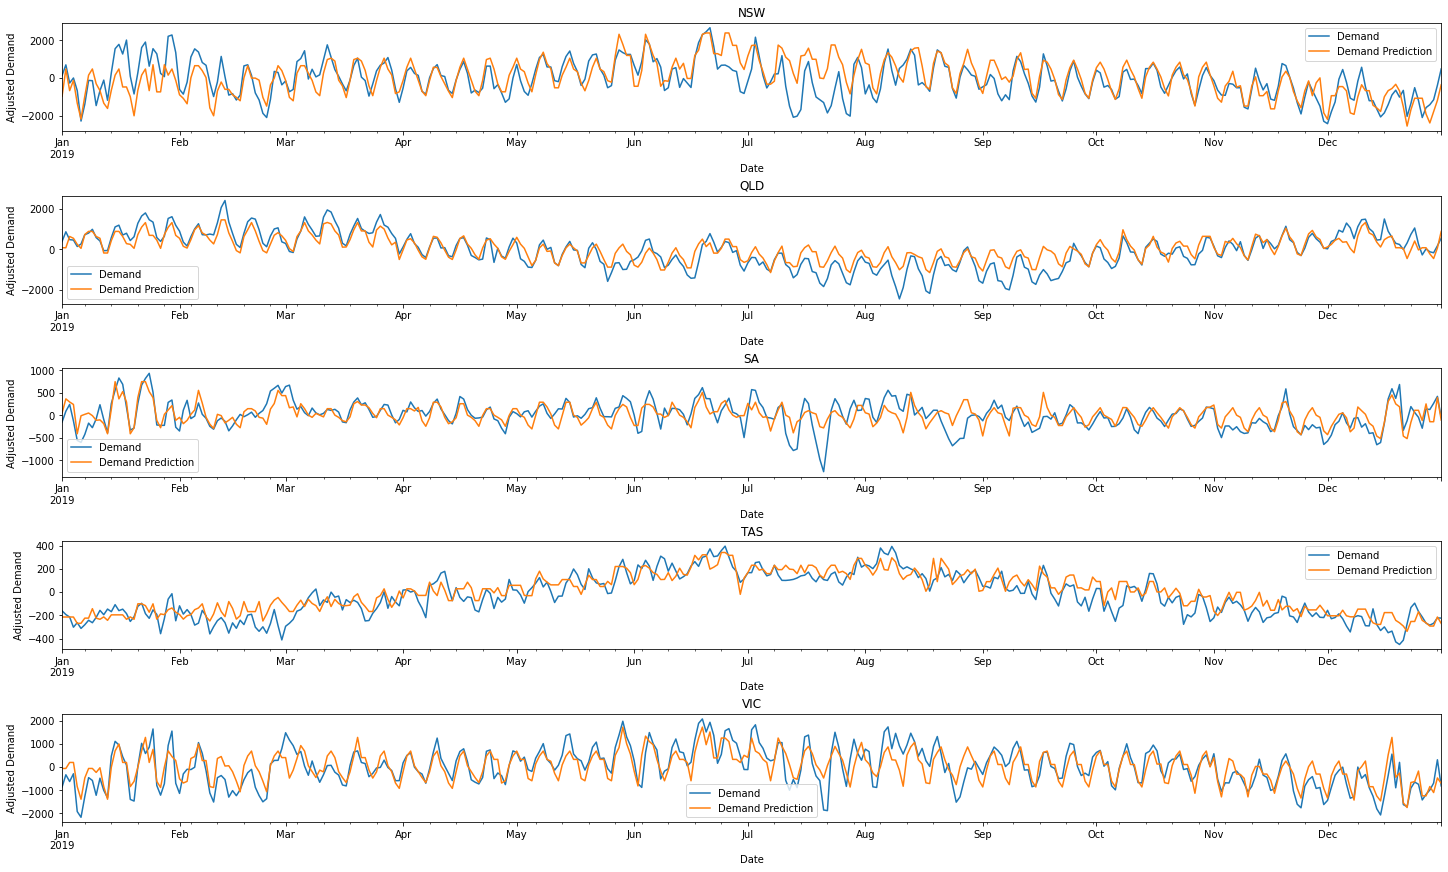

In [13]:
fig, axes = plt.subplots(nrows=5, figsize=(20, 12), constrained_layout=True)

for i, (region, region_data) in enumerate(test_data.groupby("Region")):
    region_data[output_columns]["2019"].plot(ax=axes[i], title=region)
    test_predictions[i][output_columns]["2019"].plot(ax=axes[i])
    axes[i].set_ylabel("Adjusted Demand")
    axes[i].legend(["Demand", "Demand Prediction"])
    
pass;